In [26]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import copy

(-109.96101722357977, 109.96101722357979, -109.85118304606, 109.99291347838381)

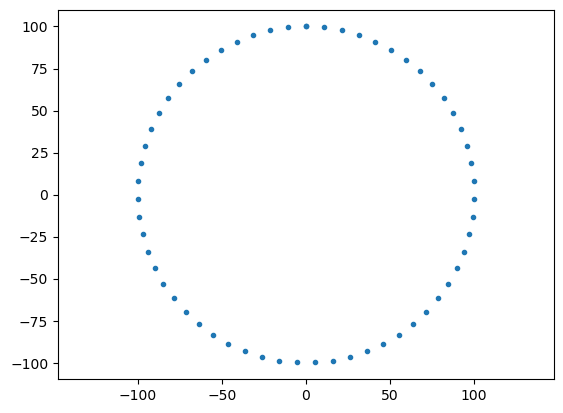

In [2]:
Y_rad = 100

def generate_S1_S2(Y_rad, number_of_points = 60):
    angles = np.linspace(0, 2*np.pi, number_of_points)
    x = Y_rad*np.sin(angles)
    y = Y_rad*np.cos(angles)
    return x,y


def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])
    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())

testx, testy = generate_S1_S2(Y_rad)
plt.plot(testx, testy, '.')
plt.axis('equal')

In [34]:
d_dict = { 'Y': 10, 'H': 990 }
Y_func = lambda eqps, d_dict: (d_dict['Y'] + eqps*d_dict['H'])*np.sqrt(2/3)

# generate Pi plane S1,S2 for various eqps
number_of_eqps_values = 21
number_of_stress_strain_curves = 60
eqps_values = np.array([ i*0.01 for i in range(number_of_eqps_values) ])

all_data = []
implicit_formatted_data = [ [] for i in range(number_of_eqps_values) ]

for i, eqps in enumerate(eqps_values):
    Y_rad = Y_func(eqps, d_dict)
    # All this data corresponds to a single eqps value
    testx, testy = generate_S1_S2(Y_rad, number_of_stress_strain_curves)
    testz = np.zeros(len(testx))
    # This can be immediately entered into implicit data after rotation
    stresses_pi = np.column_stack([testx, testy, testz])
    # Rotate these stresses out of pi plane
    stresses = stresses_pi @ align_pi_plane_with_axes_rot()
    eqps_col = np.ones(len(testx))*eqps
    stresses = np.column_stack([stresses, eqps_col])
    all_data.append(stresses)

    implicit_formatted_data[i] = stresses

all_data = np.array(all_data)

explicit_formatted_data = None

nan_line = np.array([np.nan for i in range(4)])

# Build the explicit formatted array
for ss_curve in range(number_of_stress_strain_curves):
    # Grab all in this index along ss_curve
    yield_traj = all_data[:,ss_curve]
    if ss_curve == 0:
        explicit_formatted_data = yield_traj
    else:
        explicit_formatted_data = np.vstack([explicit_formatted_data, yield_traj])
    if ss_curve != number_of_stress_strain_curves - 1:
        explicit_formatted_data = np.vstack([explicit_formatted_data, nan_line])
    
implicit_formatted_data_copy = copy.copy(implicit_formatted_data)
implicit_formatted_data = None
for i, e in enumerate(implicit_formatted_data_copy):
    if i == 0:
        implicit_formatted_data = e
    else:
        implicit_formatted_data = np.vstack([implicit_formatted_data, e])
    if i != (number_of_eqps_values-1):
        implicit_formatted_data = np.vstack([implicit_formatted_data, nan_line])

#print(implicit_formatted_data)

n = 1
np.savetxt(f"processed_data/vm_{n}_transpose_bingo_format.txt", implicit_formatted_data)
np.savetxt(f"processed_data/vm_{n}_bingo_format.txt", explicit_formatted_data)

[[ 1.7254603  -6.43950551  4.71404521  0.        ]
 [ 1.03120774 -6.21961923  5.1884115   0.        ]
 [ 0.32527118 -5.92926219  5.60399101  0.        ]
 [-0.38435083 -5.57172423  5.95607507  0.        ]
 [-1.089618   -5.15105641  6.24067441  0.        ]
 [-1.78253935 -4.67202507  6.45456442  0.        ]
 [-2.45526383 -4.14005781  6.59532164  0.        ]
 [-3.10016918 -3.56118205  6.66135123  0.        ]
 [-3.70994838 -2.94195667  6.65190504  0.        ]
 [-4.27769238 -2.28939774  6.56709012  0.        ]
 [-4.79696841 -1.61089902  6.40786743  0.        ]
 [-5.26189288 -0.91414818  6.17604106  0.        ]
 [-5.667198   -0.20703967  5.87423766  0.        ]
 [-6.0082915   0.50241469  5.50587681  0.        ]
 [-6.28130865  1.20617648  5.07513217  0.        ]
 [-6.48315607  1.89627181  4.58688426  0.        ]
 [-6.61154674  2.56488163  4.04666512  0.        ]
 [-6.66502595  3.20443031  3.46059564  0.        ]
 [-6.64298775  3.80767151  2.83531623  0.        ]
 [-6.54568184  4.36777028  2.17